<a href="https://colab.research.google.com/github/Kielu91/vegetable-classification-cnn/blob/main/vegetable_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub -q
import kagglehub

# Download latest version
path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vegetable-image-dataset


In [ ]:
import os
import time
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import random
import matplotlib.image as mpimg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Używane urządzenie: {device}')

Używane urządzenie: cpu


In [ ]:
print("Zawartość folderu datasetu:")
print(os.listdir(path))


Zawartość folderu datasetu:
['Vegetable Images']


In [ ]:
print("Zawartość podfolderów:")
for f in os.listdir(path):
    print(f, "->", os.listdir(os.path.join(path, f)) if os.path.isdir(os.path.join(path, f)) else "plik")

Zawartość podfolderów:
Vegetable Images -> ['validation', 'test', 'train']


In [ ]:
# === Dane ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images"
train_folder = os.path.join(dataset_path, 'train')
train_data = ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)
val_data = ImageFolder(os.path.join(dataset_path, 'validation'), transform=transform)
test_data = ImageFolder(os.path.join(dataset_path, 'test'), transform=transform)
classes = train_data.classes

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

print("Liczba klas:", len(train_data.classes))
print("Klasy:", train_data.classes)
print(f"Długość train dataloader: {len(train_loader)} paczek o 64 próbkach")
print(f"Długość valid dataloader: {len(val_loader)} paczek o 64 próbkach")
print(f"Długość test dataloader: {len(test_loader)} paczek o 64 próbkach")

Liczba klas: 15
Klasy: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Długość train dataloader: 235 paczek o 64 próbkach
Długość valid dataloader: 47 paczek o 64 próbkach
Długość test dataloader: 47 paczek o 64 próbkach



ANALIZA ROZKŁADU DANYCH
Klasa                Train    Valid    Test     Razem   
------------------------------------------------------------
Bean                 1000     200      200      1400    
Bitter_Gourd         1000     200      200      1400    
Bottle_Gourd         1000     200      200      1400    
Brinjal              1000     200      200      1400    
Broccoli             1000     200      200      1400    
Cabbage              1000     200      200      1400    
Capsicum             1000     200      200      1400    
Carrot               1000     200      200      1400    
Cauliflower          1000     200      200      1400    
Cucumber             1000     200      200      1400    
Papaya               1000     200      200      1400    
Potato               1000     200      200      1400    
Pumpkin              1000     200      200      1400    
Radish               1000     200      200      1400    
Tomato               1000     200      200      1400    
--

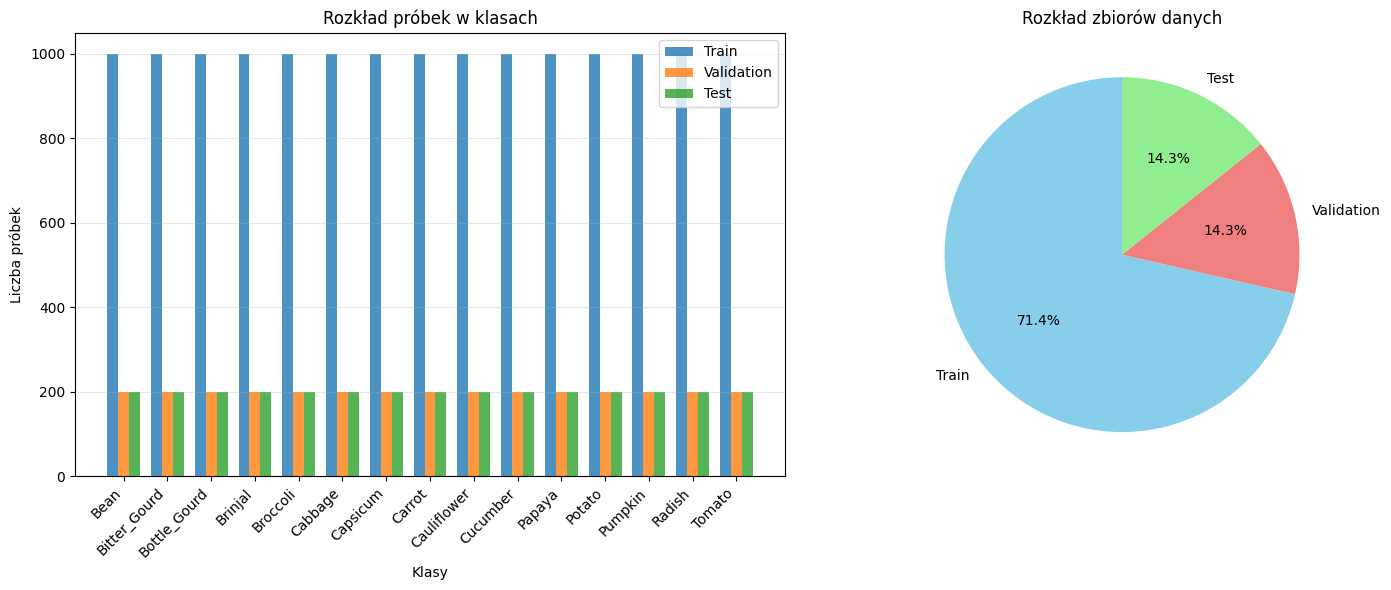

In [ ]:
# === Analiza rozkładu danych ===
def analyze_dataset_distribution():
    """Analiza rozkładu klas w zbiorach danych"""
    print("\n" + "="*60)
    print("ANALIZA ROZKŁADU DANYCH")
    print("="*60)

    # Zliczanie próbek w każdym zbiorze
    train_counts = Counter()
    val_counts = Counter()
    test_counts = Counter()

    # Zliczanie dla train
    for _, label in train_data:
        train_counts[classes[label]] += 1

    # Zliczanie dla validation
    for _, label in val_data:
        val_counts[classes[label]] += 1

    # Zliczanie dla test
    for _, label in test_data:
        test_counts[classes[label]] += 1

    # Wyświetlanie wyników
    print(f"{'Klasa':<20} {'Train':<8} {'Valid':<8} {'Test':<8} {'Razem':<8}")
    print("-" * 60)

    total_train, total_val, total_test = 0, 0, 0
    for class_name in classes:
        train_count = train_counts[class_name]
        val_count = val_counts[class_name]
        test_count = test_counts[class_name]
        total = train_count + val_count + test_count

        print(f"{class_name:<20} {train_count:<8} {val_count:<8} {test_count:<8} {total:<8}")
        total_train += train_count
        total_val += val_count
        total_test += test_count

    print("-" * 60)
    total_all = total_train + total_val + total_test
    print(f"{'RAZEM':<20} {total_train:<8} {total_val:<8} {total_test:<8} {total_all:<8}")

    # Procentowy rozkład
    print(f"\nProcentowy rozkład zbiorów:")
    print(f"Train: {total_train/total_all*100:.1f}%")
    print(f"Validation: {total_val/total_all*100:.1f}%")
    print(f"Test: {total_test/total_all*100:.1f}%")

    # Wykres rozkładu
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Wykres słupkowy dla każdej klasy
    class_names = list(classes)
    train_vals = [train_counts[c] for c in class_names]
    val_vals = [val_counts[c] for c in class_names]
    test_vals = [test_counts[c] for c in class_names]

    x = np.arange(len(class_names))
    width = 0.25

    ax1.bar(x - width, train_vals, width, label='Train', alpha=0.8)
    ax1.bar(x, val_vals, width, label='Validation', alpha=0.8)
    ax1.bar(x + width, test_vals, width, label='Test', alpha=0.8)

    ax1.set_xlabel('Klasy')
    ax1.set_ylabel('Liczba próbek')
    ax1.set_title('Rozkład próbek w klasach')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Wykres kołowy dla całkowitego rozkładu zbiorów
    sizes = [total_train, total_val, total_test]
    labels = ['Train', 'Validation', 'Test']
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Rozkład zbiorów danych')

    plt.tight_layout()
    plt.show()

analyze_dataset_distribution()

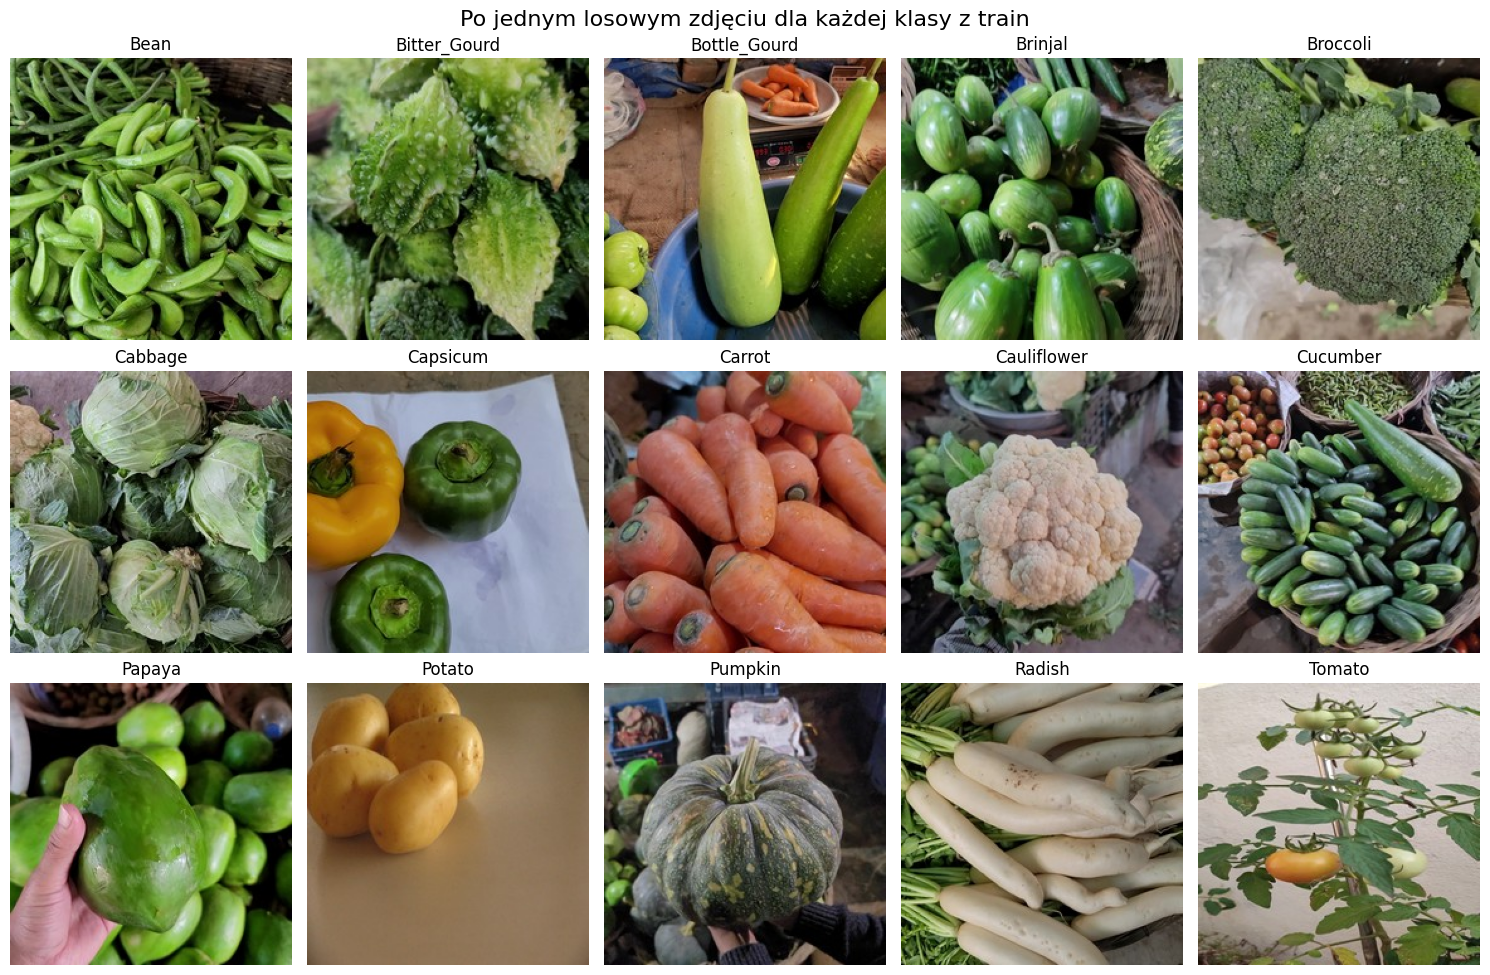

In [ ]:
# ============= wyświetlanie po 1 obrazku z każdej klasy ===============

# słownik: klasa -> lista ścieżek do obrazków
class_to_paths = {cls: [] for cls in train_data.classes}
for path_img, label_idx in train_data.samples:
    class_name = train_data.classes[label_idx]
    class_to_paths[class_name].append(path_img)

# Wybierz losowo po jednym zdjęciu z każdej klasy
sampled_images = {cls: random.choice(paths) for cls, paths in class_to_paths.items()}

# Wyświetl
plt.figure(figsize=(15, 10))
for i, (cls, img_path) in enumerate(sampled_images.items()):
    img = mpimg.imread(img_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Po jednym losowym zdjęciu dla każdej klasy z train", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 64, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 2, stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256 * 2 * 2, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes, bias=False)

    def get_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        features = F.relu(self.fc1(x))
        return features

    def forward(self, x):
        features = self.get_features(x)
        x = self.fc2(features)
        return x
#======================================================================

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total


def validate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total


def extract_features(model, dataloader):
    model.eval()
    features_list, labels_list, probs_list = [], [], []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            features = model.get_features(inputs)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            probs_list.append(probs)
    return (np.concatenate(features_list),
            np.concatenate(labels_list),
            np.concatenate(probs_list))


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train loss', marker='o', linewidth=2)
    plt.plot(val_losses, label='Validation loss', marker='s', linewidth=2)
    plt.xlabel('Epoka')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Straty w czasie trenowania')
    plt.grid(alpha=0.3)
    plt.show()


def plot_confusion_matrices(y_true, y_pred_cnn, y_pred_rf, classes):
    """Macierze pomyłek z pionowymi etykietami na osi X"""
    cm_cnn = confusion_matrix(y_true, y_pred_cnn)
    cm_rf = confusion_matrix(y_true, y_pred_rf)

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    # CNN Confusion Matrix
    im1 = ConfusionMatrixDisplay(cm_cnn, display_labels=classes).plot(ax=ax[0], cmap='Blues', colorbar=False)
    ax[0].set_title("Macierz pomyłek - CNN", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Predykcja", fontsize=12)
    ax[0].set_ylabel("Prawdziwa klasa", fontsize=12)
    # Pionowe etykiety na osi X
    ax[0].set_xticklabels(classes, rotation=90, ha='center')
    ax[0].set_yticklabels(classes, rotation=0)

    # Random Forest Confusion Matrix
    im2 = ConfusionMatrixDisplay(cm_rf, display_labels=classes).plot(ax=ax[1], cmap='Greens', colorbar=False)
    ax[1].set_title("Macierz pomyłek - Random Forest", fontsize=14, fontweight='bold')
    ax[1].set_xlabel("Predykcja", fontsize=12)
    ax[1].set_ylabel("Prawdziwa klasa", fontsize=12)
    # Pionowe etykiety na osi X
    ax[1].set_xticklabels(classes, rotation=90, ha='center')
    ax[1].set_yticklabels(classes, rotation=0)

    plt.tight_layout()
    plt.show()


def plot_roc_curves(y_true, probs_cnn, probs_rf, classes):
    """Krzywe ROC z dodatkowymi informacjami"""
    n_classes = len(classes)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

    # ROC dla CNN
    fpr_cnn = dict()
    tpr_cnn = dict()
    roc_auc_cnn = dict()

    for i in range(n_classes):
        fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_true == i, probs_cnn[:, i])
        roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

    # Wykres ROC CNN
    for i in range(n_classes):
        ax1.plot(fpr_cnn[i], tpr_cnn[i],
                label=f'{classes[i]} (AUC={roc_auc_cnn[i]:.3f})', linewidth=2)
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.8, label='Losowy klasyfikator')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Krzywe ROC - CNN')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(alpha=0.3)

    # ROC dla Random Forest
    fpr_rf = dict()
    tpr_rf = dict()
    roc_auc_rf = dict()

    for i in range(n_classes):
        fpr_rf[i], tpr_rf[i], _ = roc_curve(y_true == i, probs_rf[:, i])
        roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    for i in range(n_classes):
        ax2.plot(fpr_rf[i], tpr_rf[i],
                label=f'{classes[i]} (AUC={roc_auc_rf[i]:.3f})', linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.8, label='Losowy klasyfikator')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Krzywe ROC - Random Forest')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(alpha=0.3)

    # Porównanie średnich AUC
    mean_auc_cnn = np.mean(list(roc_auc_cnn.values()))
    mean_auc_rf = np.mean(list(roc_auc_rf.values()))

    models = ['CNN', 'Random Forest']
    aucs = [mean_auc_cnn, mean_auc_rf]
    colors = ['lightblue', 'lightgreen']

    bars = ax3.bar(models, aucs, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Średnia AUC')
    ax3.set_title('Porównanie średniej AUC')
    ax3.set_ylim([0, 1])
    ax3.grid(axis='y', alpha=0.3)

    # Dodanie wartości na słupkach
    for bar, auc_val in zip(bars, aucs):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold')

    # Tabela z wynikami AUC
    auc_data = []
    for i, class_name in enumerate(classes):
        auc_data.append([class_name, f"{roc_auc_cnn[i]:.3f}", f"{roc_auc_rf[i]:.3f}"])
    auc_data.append(['Średnia', f"{mean_auc_cnn:.3f}", f"{mean_auc_rf:.3f}"])

    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=auc_data,
                     colLabels=['Klasa', 'CNN AUC', 'RF AUC'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Tabela wyników AUC', pad=20, fontweight='bold')

    plt.tight_layout()
    plt.show()


def plot_precision_recall_curves(y_true, probs_cnn, probs_rf, classes):
    """Krzywe Precision-Recall"""
    n_classes = len(classes)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Precision-Recall dla CNN
    pr_auc_cnn = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, probs_cnn[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_cnn.append(pr_auc)

        baseline = np.sum(y_true == i) / len(y_true)
        ax1.plot(recall, precision,
                label=f'{classes[i]} (AUC={pr_auc:.3f})', linewidth=2)

    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Krzywe Precision-Recall - CNN')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(alpha=0.3)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])

    # Precision-Recall dla Random Forest
    pr_auc_rf = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, probs_rf[:, i])
        pr_auc = auc(recall, precision)
        pr_auc_rf.append(pr_auc)

        ax2.plot(recall, precision,
                label=f'{classes[i]} (AUC={pr_auc:.3f})', linewidth=2)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Krzywe Precision-Recall - Random Forest')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()

    return pr_auc_cnn, pr_auc_rf

def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """Wykres strat i dokładności w czasie trenowania"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(train_losses) + 1)

    # Wykres strat
    ax1.plot(epochs, train_losses, 'b-o', label='Train loss', linewidth=2, markersize=6)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation loss', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoka')
    ax1.set_ylabel('Loss')
    ax1.set_title('Straty w czasie trenowania')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_xlim([1, len(epochs)])

    # Wykres dokładności
    ax2.plot(epochs, train_accuracies, 'b-o', label='Train accuracy', linewidth=2, markersize=6)
    ax2.plot(epochs, val_accuracies, 'r-s', label='Validation accuracy', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoka')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Dokładność w czasie trenowania')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim([1, len(epochs)])
    ax2.set_ylim([0, 1])

    # Wykres różnicy między train a validation loss
    loss_diff = [abs(t - v) for t, v in zip(train_losses, val_losses)]
    ax3.plot(epochs, loss_diff, 'g-^', label='|Train - Val| Loss', linewidth=2, markersize=6)
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel('Różnica Loss')
    ax3.set_title('Różnica między Train a Validation Loss')
    ax3.legend()
    ax3.grid(alpha=0.3)
    ax3.set_xlim([1, len(epochs)])

    # Wykres różnicy między train a validation accuracy
    acc_diff = [abs(t - v) for t, v in zip(train_accuracies, val_accuracies)]
    ax4.plot(epochs, acc_diff, 'purple', linestyle='--', marker='d',
             label='|Train - Val| Accuracy', linewidth=2, markersize=6)
    ax4.set_xlabel('Epoka')
    ax4.set_ylabel('Różnica Accuracy')
    ax4.set_title('Różnica między Train a Validation Accuracy')
    ax4.legend()
    ax4.grid(alpha=0.3)
    ax4.set_xlim([1, len(epochs)])

    plt.tight_layout()
    plt.show()


def plot_learning_curves_detailed(train_losses, val_losses, train_accuracies, val_accuracies):
    """Szczegółowe krzywe uczenia z dodatkowymi informacjami"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    epochs = range(1, len(train_losses) + 1)

    # Wykres strat z wypełnionym obszarem
    ax1.fill_between(epochs, train_losses, alpha=0.3, color='blue', label='Train loss area')
    ax1.fill_between(epochs, val_losses, alpha=0.3, color='red', label='Validation loss area')
    ax1.plot(epochs, train_losses, 'b-o', label='Train loss', linewidth=2, markersize=4)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation loss', linewidth=2, markersize=4)

    # Dodanie linii dla najlepszej epoki
    best_epoch = np.argmin(val_losses) + 1
    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7,
                label=f'Najlepsza epoka: {best_epoch}')

    ax1.set_xlabel('Epoka', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Krzywe uczenia - Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_xlim([1, len(epochs)])

    # Dodanie tekstu z wartościami
    min_val_loss = min(val_losses)
    final_train_loss = train_losses[-1]
    ax1.text(0.02, 0.98, f'Min Val Loss: {min_val_loss:.4f}\nFinal Train Loss: {final_train_loss:.4f}',
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Wykres dokładności z wypełnionym obszarem
    ax2.fill_between(epochs, train_accuracies, alpha=0.3, color='blue', label='Train accuracy area')
    ax2.fill_between(epochs, val_accuracies, alpha=0.3, color='red', label='Validation accuracy area')
    ax2.plot(epochs, train_accuracies, 'b-o', label='Train accuracy', linewidth=2, markersize=4)
    ax2.plot(epochs, val_accuracies, 'r-s', label='Validation accuracy', linewidth=2, markersize=4)

    # Dodanie linii dla najlepszej epoki
    best_acc_epoch = np.argmax(val_accuracies) + 1
    ax2.axvline(x=best_acc_epoch, color='green', linestyle='--', alpha=0.7,
                label=f'Najlepsza acc epoka: {best_acc_epoch}')

    ax2.set_xlabel('Epoka', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Krzywe uczenia - Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim([1, len(epochs)])
    ax2.set_ylim([0, 1])

    # Dodanie tekstu z wartościami
    max_val_acc = max(val_accuracies)
    final_train_acc = train_accuracies[-1]
    ax2.text(0.02, 0.02, f'Max Val Acc: {max_val_acc:.4f}\nFinal Train Acc: {final_train_acc:.4f}',
             transform=ax2.transAxes, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    plt.tight_layout()
    plt.show()

In [ ]:
# === Model ===
model = SimpleCNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,
                                                       threshold=1e-4, threshold_mode='rel', cooldown=1, min_lr=1e-6)
# === Trenowanie ===
best_val_loss = np.inf
patience = 5
counter = 0
best_model_weights = copy.deepcopy(model.state_dict())
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"\nRozpoczynanie trenowania...")
print(f"Liczba parametrów modelu: {count_parameters(model):,}")
start_time = time.time()

for epoch in range(30):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/30: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f"Nowy najlepszy model zapisany")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

model.load_state_dict(best_model_weights)
end_time = time.time()

print(f"\nCzas trenowania: {(end_time - start_time) / 60:.2f} minut")
print(f"Najlepsza val_loss: {best_val_loss:.4f}")
print(f"Najlepsza val_accuracy: {max(val_accuracies):.4f}")


Rozpoczynanie trenowania...
Liczba parametrów modelu: 287,568


Train: 100%|██████████| 235/235 [00:48<00:00,  4.84it/s]


Epoch 1/30: train_loss=0.9748, train_acc=0.6843, val_loss=0.5007, val_acc=0.8420
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:49<00:00,  4.70it/s]


Epoch 2/30: train_loss=0.3923, train_acc=0.8719, val_loss=0.2877, val_acc=0.9053
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:49<00:00,  4.75it/s]


Epoch 3/30: train_loss=0.2391, train_acc=0.9229, val_loss=0.2059, val_acc=0.9303
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:59<00:00,  3.95it/s]


Epoch 4/30: train_loss=0.1833, train_acc=0.9419, val_loss=0.2970, val_acc=0.8987


Train: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


Epoch 5/30: train_loss=0.1569, train_acc=0.9492, val_loss=0.1890, val_acc=0.9420
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:49<00:00,  4.71it/s]


Epoch 6/30: train_loss=0.1260, train_acc=0.9591, val_loss=0.1716, val_acc=0.9400
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:49<00:00,  4.77it/s]


Epoch 7/30: train_loss=0.1154, train_acc=0.9622, val_loss=0.1549, val_acc=0.9473
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


Epoch 8/30: train_loss=0.0891, train_acc=0.9709, val_loss=0.1297, val_acc=0.9570
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:52<00:00,  4.46it/s]


Epoch 9/30: train_loss=0.0847, train_acc=0.9712, val_loss=0.1260, val_acc=0.9623
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:50<00:00,  4.61it/s]


Epoch 10/30: train_loss=0.0799, train_acc=0.9741, val_loss=0.1333, val_acc=0.9543


Train: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s]


Epoch 11/30: train_loss=0.0715, train_acc=0.9755, val_loss=0.1570, val_acc=0.9510


Train: 100%|██████████| 235/235 [00:50<00:00,  4.65it/s]


Epoch 12/30: train_loss=0.0760, train_acc=0.9751, val_loss=0.1156, val_acc=0.9643
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:51<00:00,  4.60it/s]


Epoch 13/30: train_loss=0.0653, train_acc=0.9787, val_loss=0.1192, val_acc=0.9630


Train: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s]


Epoch 14/30: train_loss=0.0513, train_acc=0.9828, val_loss=0.2346, val_acc=0.9287


Train: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


Epoch 15/30: train_loss=0.0423, train_acc=0.9855, val_loss=0.0882, val_acc=0.9730
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s]


Epoch 16/30: train_loss=0.0617, train_acc=0.9793, val_loss=0.1661, val_acc=0.9450


Train: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


Epoch 17/30: train_loss=0.0508, train_acc=0.9831, val_loss=0.0885, val_acc=0.9777


Train: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s]


Epoch 18/30: train_loss=0.0366, train_acc=0.9877, val_loss=0.0696, val_acc=0.9797
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:53<00:00,  4.36it/s]


Epoch 19/30: train_loss=0.0473, train_acc=0.9835, val_loss=0.1017, val_acc=0.9720


Train: 100%|██████████| 235/235 [00:51<00:00,  4.58it/s]


Epoch 20/30: train_loss=0.0392, train_acc=0.9869, val_loss=0.1486, val_acc=0.9543


Train: 100%|██████████| 235/235 [00:50<00:00,  4.61it/s]


Epoch 21/30: train_loss=0.0435, train_acc=0.9855, val_loss=0.0717, val_acc=0.9787


Train: 100%|██████████| 235/235 [00:51<00:00,  4.55it/s]


Epoch 22/30: train_loss=0.0147, train_acc=0.9957, val_loss=0.0380, val_acc=0.9890
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:50<00:00,  4.66it/s]


Epoch 23/30: train_loss=0.0109, train_acc=0.9965, val_loss=0.0334, val_acc=0.9893
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:50<00:00,  4.67it/s]


Epoch 24/30: train_loss=0.0101, train_acc=0.9971, val_loss=0.0490, val_acc=0.9870


Train: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s]


Epoch 25/30: train_loss=0.0071, train_acc=0.9980, val_loss=0.0370, val_acc=0.9907


Train: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


Epoch 26/30: train_loss=0.0084, train_acc=0.9977, val_loss=0.0434, val_acc=0.9887


Train: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s]


Epoch 27/30: train_loss=0.0070, train_acc=0.9983, val_loss=0.0352, val_acc=0.9903


Train: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s]


Epoch 28/30: train_loss=0.0040, train_acc=0.9986, val_loss=0.0332, val_acc=0.9923
Nowy najlepszy model zapisany


Train: 100%|██████████| 235/235 [00:51<00:00,  4.56it/s]


Epoch 29/30: train_loss=0.0040, train_acc=0.9986, val_loss=0.0344, val_acc=0.9907


Train: 100%|██████████| 235/235 [00:55<00:00,  4.26it/s]


Epoch 30/30: train_loss=0.0050, train_acc=0.9985, val_loss=0.0312, val_acc=0.9913
Nowy najlepszy model zapisany

Czas trenowania: 28.94 minut
Najlepsza val_loss: 0.0312
Najlepsza val_accuracy: 0.9923


In [ ]:
# === Ekstrakcja cech i klasyfikator RF ===
print("\nEkstraktowanie cech...")
X_train, y_train, _ = extract_features(model, train_loader)
X_test, y_test, p_test_cnn = extract_features(model, test_loader)
print(X_train.shape)
print("Trenowanie Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
y_pred_rf_proba = clf.predict_proba(X_test)


Ekstraktowanie cech...


Validation: 100%|██████████| 47/47 [00:09<00:00,  5.02it/s]


(15000, 64)
Trenowanie Random Forest...


In [ ]:
# === Metryki ===
y_pred_cnn = np.argmax(p_test_cnn, axis=1)
ACC_cnn = accuracy_score(y_test, y_pred_cnn)
AUC_cnn = roc_auc_score(y_test, p_test_cnn, multi_class='ovr')

ACC_rf = accuracy_score(y_test, y_pred_rf)
AUC_rf = roc_auc_score(y_test, y_pred_rf_proba, multi_class='ovr')

print(f"CNN: ACC={ACC_cnn:.4f}, AUC={AUC_cnn:.4f}")
print(f"RandomForest: ACC={ACC_rf:.4f}, AUC={AUC_rf:.4f}")

# === Raporty ===
from sklearn.metrics import classification_report
print("\nRaport klasyfikacji CNN:")
print(classification_report(y_test, y_pred_cnn, target_names=classes))
print("\nRaport klasyfikacji Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=classes))


CNN: ACC=0.9887, AUC=0.9999
RandomForest: ACC=0.9877, AUC=0.9999

Raport klasyfikacji CNN:
              precision    recall  f1-score   support

        Bean       0.99      0.98      0.98       200
Bitter_Gourd       0.98      0.98      0.98       200
Bottle_Gourd       1.00      1.00      1.00       200
     Brinjal       0.99      0.99      0.99       200
    Broccoli       0.99      0.99      0.99       200
     Cabbage       0.98      0.99      0.98       200
    Capsicum       1.00      0.99      0.99       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      0.97      0.98       200
    Cucumber       0.99      1.00      1.00       200
      Papaya       0.98      1.00      0.99       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       0.97      0.97      0.97       200
      Radish       0.99      0.99      0.99       200
      Tomato       0.99      0.95      0.97       200

    accuracy                           0.99


Generowanie wykresów...


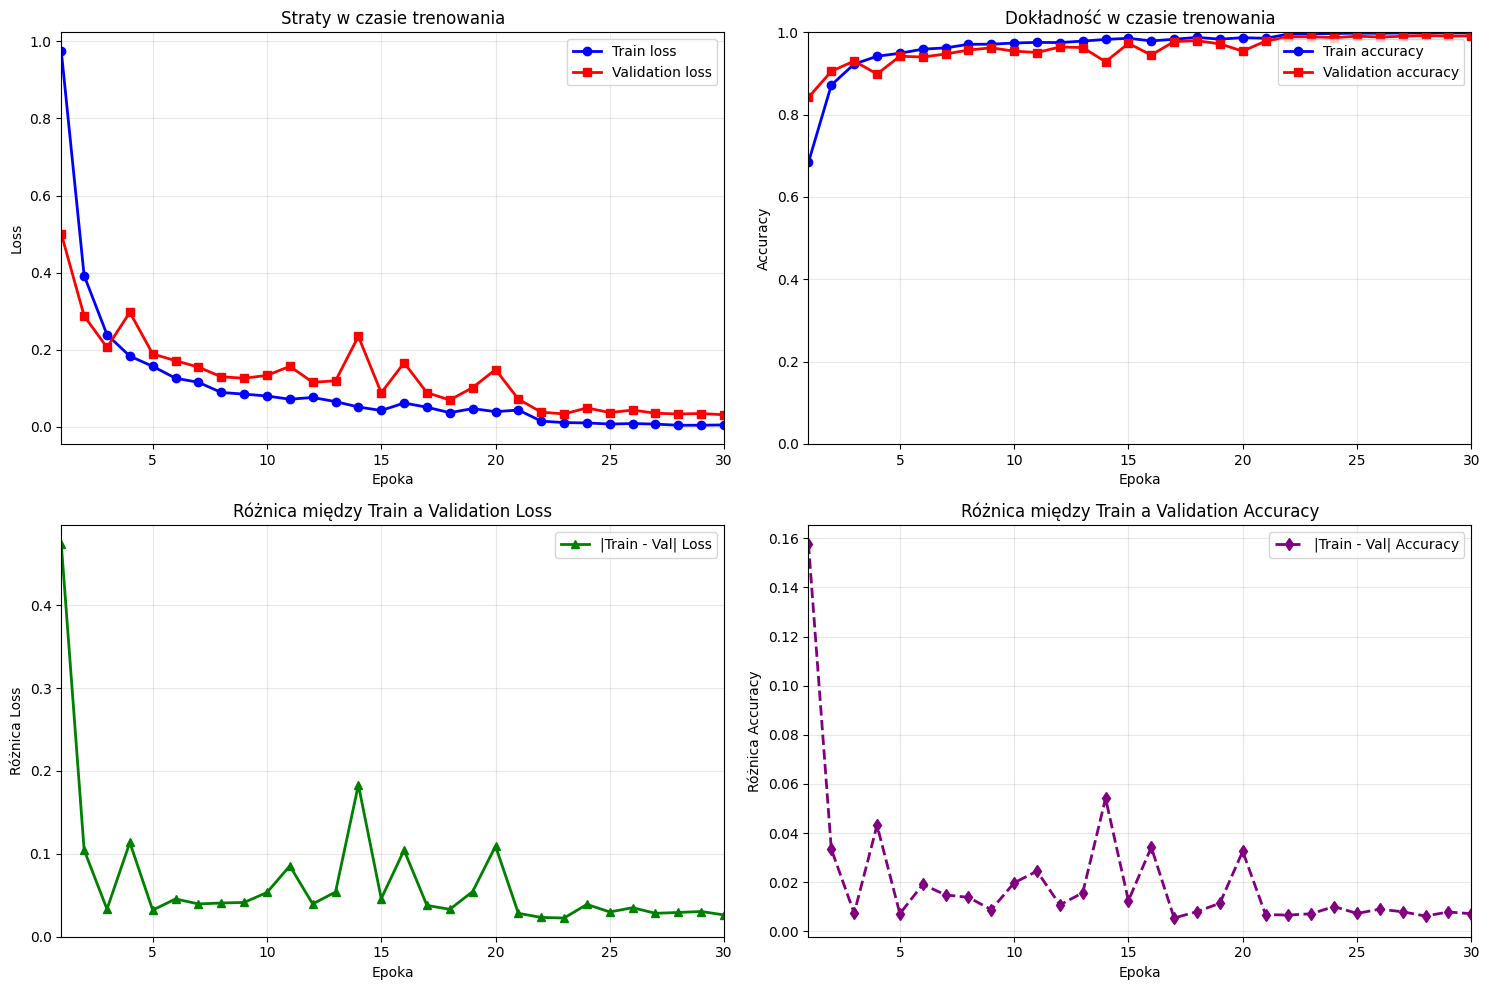

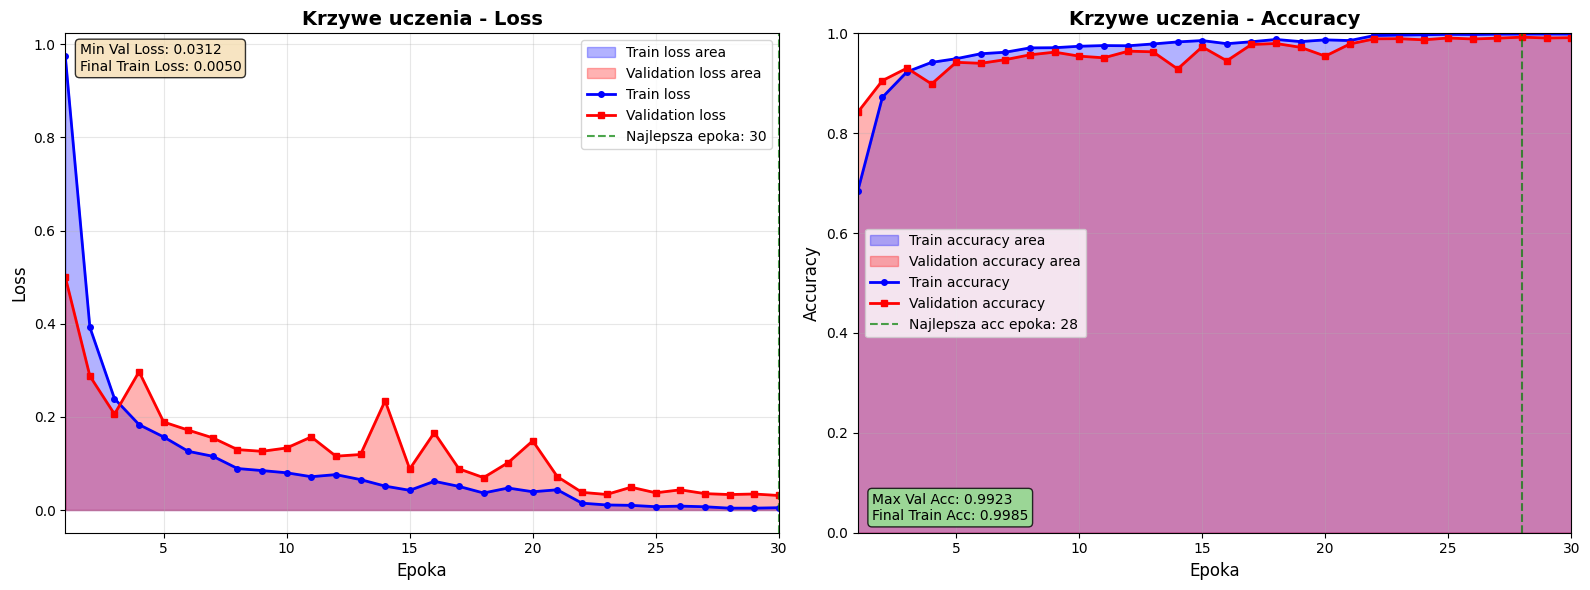

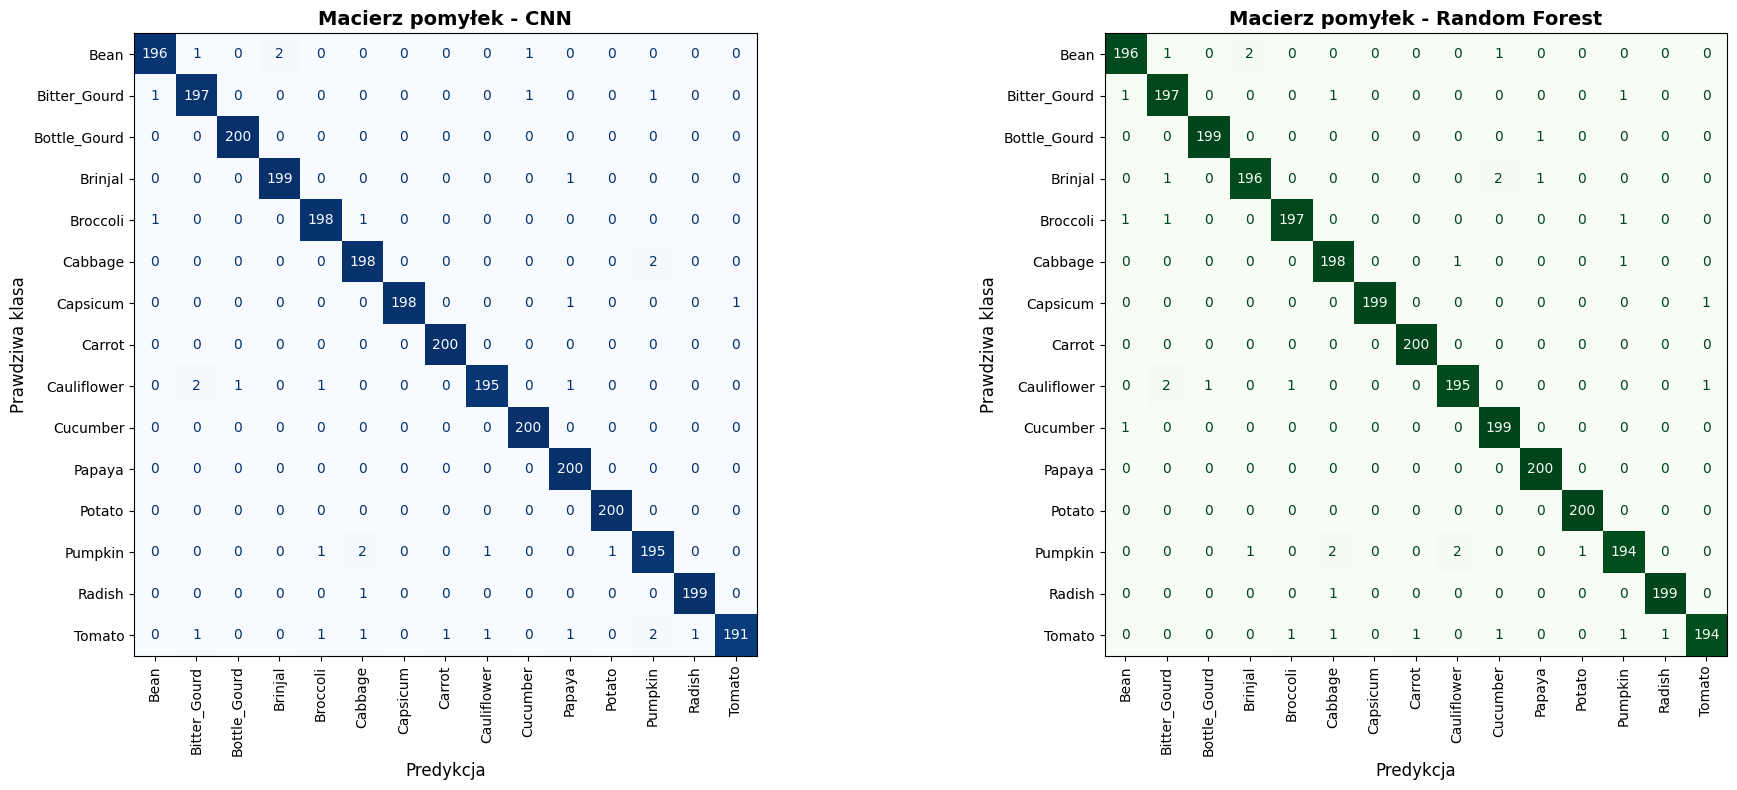

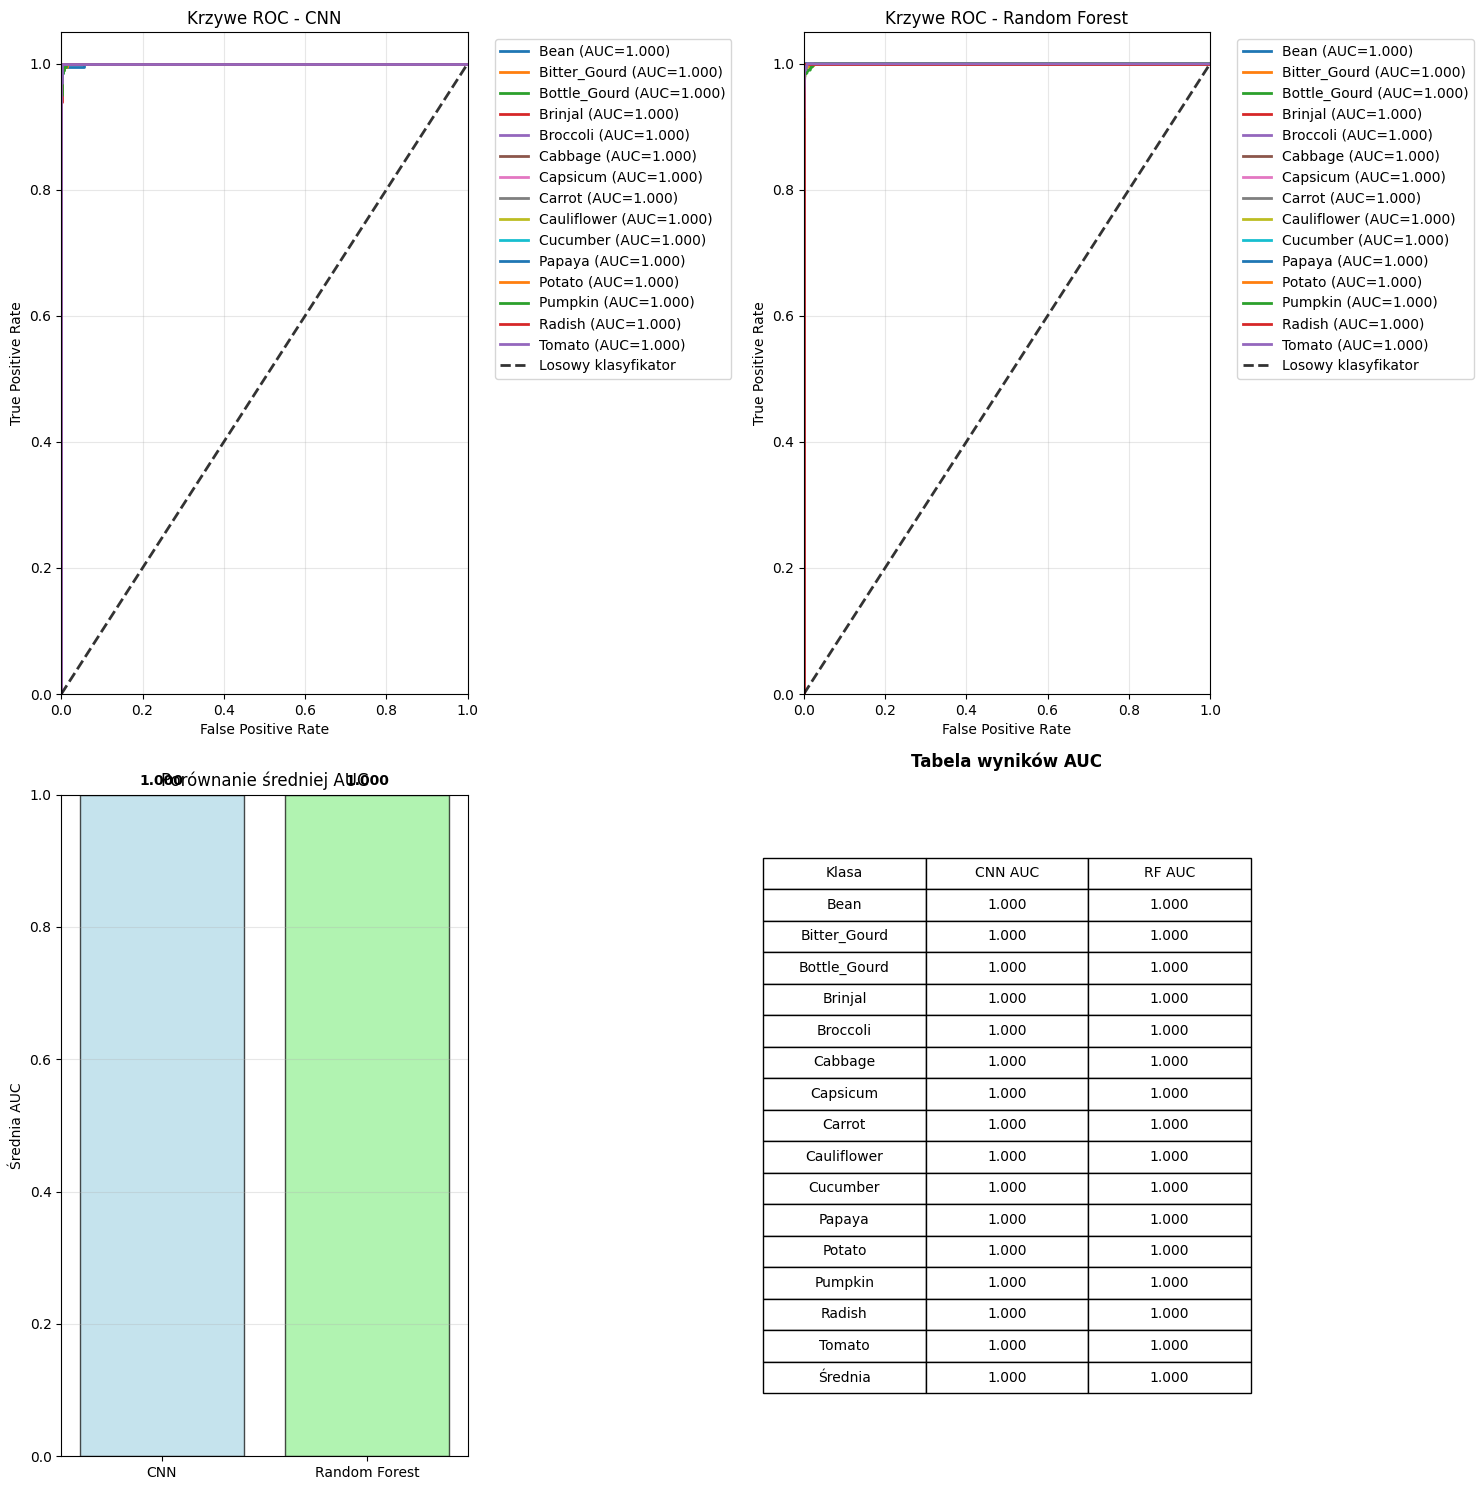

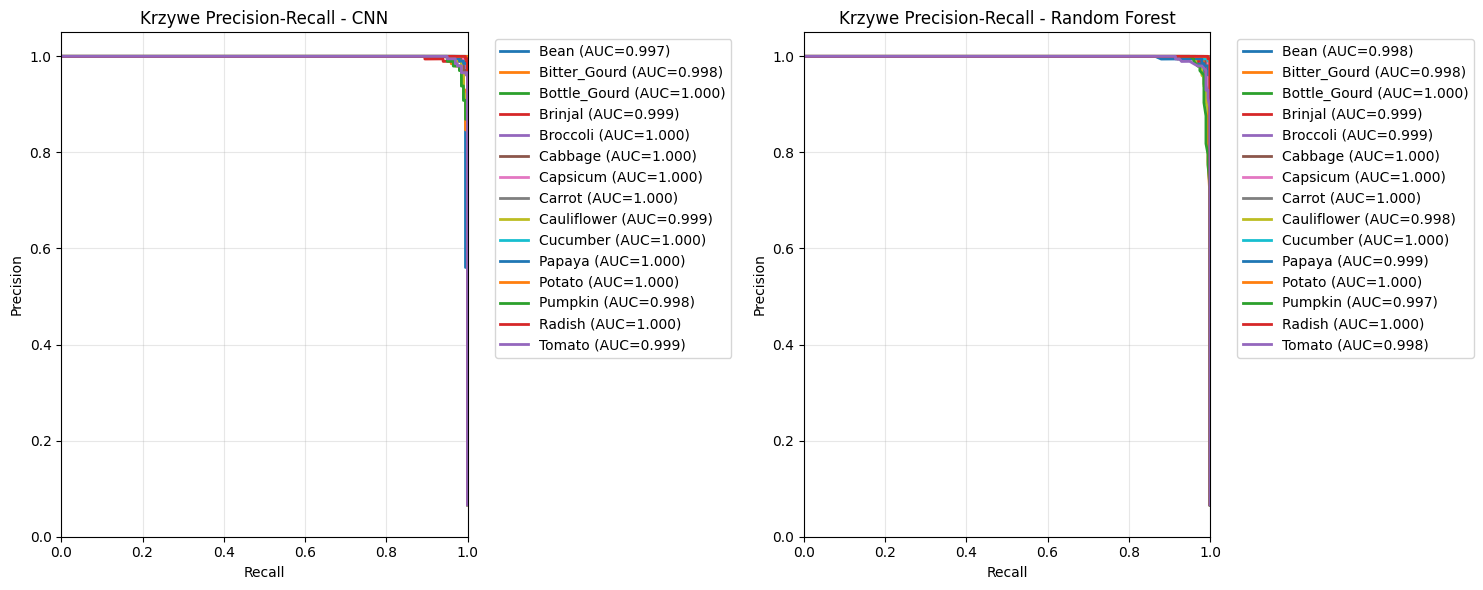

In [ ]:
# === Wykresy ===
print("\nGenerowanie wykresów...")
plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_learning_curves_detailed(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrices(y_test, y_pred_cnn, y_pred_rf, classes)
plot_roc_curves(y_test, p_test_cnn, y_pred_rf_proba, classes)
pr_auc_cnn, pr_auc_rf = plot_precision_recall_curves(y_test, p_test_cnn, y_pred_rf_proba, classes)

In [ ]:
    print("\n" + "="*80)
    print("PODSUMOWANIE WYNIKÓW EKSPERYMENTU")
    print("="*80)

    print(f"\n INFORMACJE O DANYCH:")
    print(f"   • Liczba klas: {len(classes)}")
    print(f"   • Klasy: {', '.join(classes)}")
    print(f"   • Rozmiar obrazów: 224x224 ==resize==>> 64x64 pikseli")
    print(f"   • Augmentacja danych: Tak (ColorJitter, RandomHorizontalFlip)")

    print(f"\n ARCHITEKTURA MODELU CNN:")
    print(f"   • Liczba parametrów: {count_parameters(model):,}")
    print(f"   • Warstwy konwolucyjne: 4 (48→64→128→256 kanałów)")
    print(f"   • Normalizacja: BatchNorm2d + BatchNorm1d")
    print(f"   • Regularyzacja: Dropout (0.2), Weight Decay (1e-4)")
    print(f"   • Optimizer: AdamW (lr=0.001)")

    print(f"\n  TRENOWANIE:")
    print(f"   • Czas trenowania: {(end_time - start_time) / 60:.2f} minut")
    print(f"   • Liczba epok: {len(train_losses)}")
    print(f"   • Early stopping: Tak (patience=3)")
    print(f"   • Najlepsza val_loss: {best_val_loss:.4f}")

    print(f"\n WYNIKI KLASYFIKACJI:")
    print(f"   ┌─────────────────┬──────────┬──────────┐")
    print(f"   │     Metryka     │   CNN    │    RF    │")
    print(f"   ├─────────────────┼──────────┼──────────┤")
    print(f"   │ Accuracy        │  {ACC_cnn:.4f}  │  {ACC_rf:.4f}  │")
    print(f"   │ AUC (macro)     │  {AUC_cnn:.4f}  │  {AUC_rf:.4f}  │")
    print(f"   │ PR-AUC (śred.)  │  {np.mean(pr_auc_cnn):.4f}  │  {np.mean(pr_auc_rf):.4f}  │")
    print(f"   └─────────────────┴──────────┴──────────┘")

    # Najlepsze i najgorsze klasy dla CNN
    class_accuracies_cnn = []
    class_accuracies_rf = []

    for i, class_name in enumerate(classes):
        mask = (y_test == i)
        if np.sum(mask) > 0:
            acc_cnn = accuracy_score(y_test[mask], y_pred_cnn[mask])
            acc_rf = accuracy_score(y_test[mask], y_pred_rf[mask])
            class_accuracies_cnn.append((class_name, acc_cnn))
            class_accuracies_rf.append((class_name, acc_rf))

    class_accuracies_cnn.sort(key=lambda x: x[1], reverse=True)
    class_accuracies_rf.sort(key=lambda x: x[1], reverse=True)

    print(f"\n NAJLEPSZE KLASY (CNN):")
    for i, (class_name, acc) in enumerate(class_accuracies_cnn[:3]):
        print(f"   {i+1}. {class_name}: {acc:.4f}")

    print(f"\n NAJGORSZE KLASY (CNN):")
    for i, (class_name, acc) in enumerate(class_accuracies_cnn[-3:]):
        print(f"   {len(class_accuracies_cnn)-2+i}. {class_name}: {acc:.4f}")

    print(f"\n PORÓWNANIE MODELI:")
    if ACC_cnn > ACC_rf:
        diff = ACC_cnn - ACC_rf
        print(f"   • CNN przewyższa Random Forest o {diff:.4f} punktów accuracy")
    else:
        diff = ACC_rf - ACC_cnn
        print(f"   • Random Forest przewyższa CNN o {diff:.4f} punktów accuracy")


PODSUMOWANIE WYNIKÓW EKSPERYMENTU

 INFORMACJE O DANYCH:
   • Liczba klas: 15
   • Klasy: Bean, Bitter_Gourd, Bottle_Gourd, Brinjal, Broccoli, Cabbage, Capsicum, Carrot, Cauliflower, Cucumber, Papaya, Potato, Pumpkin, Radish, Tomato
   • Rozmiar obrazów: 224x224 ==resize==>> 64x64 pikseli
   • Augmentacja danych: Tak (ColorJitter, RandomHorizontalFlip)

 ARCHITEKTURA MODELU CNN:
   • Liczba parametrów: 287,568
   • Warstwy konwolucyjne: 4 (48→64→128→256 kanałów)
   • Normalizacja: BatchNorm2d + BatchNorm1d
   • Regularyzacja: Dropout (0.2), Weight Decay (1e-4)
   • Optimizer: AdamW (lr=0.001)

  TRENOWANIE:
   • Czas trenowania: 28.94 minut
   • Liczba epok: 30
   • Early stopping: Tak (patience=3)
   • Najlepsza val_loss: 0.0312

 WYNIKI KLASYFIKACJI:
   ┌─────────────────┬──────────┬──────────┐
   │     Metryka     │   CNN    │    RF    │
   ├─────────────────┼──────────┼──────────┤
   │ Accuracy        │  0.9887  │  0.9877  │
   │ AUC (macro)     │  0.9999  │  0.9999  │
   │ PR-AUC